# 1. Environment

## 1.1 Starting

In [1]:
from unityagents import UnityEnvironment

In [2]:
env = UnityEnvironment(file_name="Banana.app")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=True)[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


## 1.2 State, Action Space and Reward

The **state** space has 37 dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  

In [3]:
state = env_info.vector_observations[0]
state_size = len(state)
print('States have length:', state_size)
print('States look like:', state)

States have length: 37
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]


Four discrete **actions** are available, corresponding to:
- **`0`** - move forward.
- **`1`** - move backward.
- **`2`** - turn left.
- **`3`** - turn right.

In [4]:
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

Number of actions: 4


A **reward** of +1 is provided for collecting a yellow banana, and a **reward** of -1 is provided for collecting a blue banana.  Thus, the goal of your agent is to collect as many yellow bananas as possible while avoiding blue bananas.  

# 2. Agent Playing - Pre Training Random Actions

In [5]:
import numpy as np
import torch
from collections import deque
import matplotlib.pyplot as plt

from model import Agent

In [10]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0)

env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]
score = 0
while True:
    action = np.random.randint(action_size)
    env_info = env.step(action)[brain_name]
    
    state = env_info.vector_observations[0]
    reward = env_info.rewards[0]
    score += reward
    
    done = env_info.local_done[0]
    if done:
        break

print('Final score:', score)

Final score: 0.0


# 3. Agent Training

In [6]:
def interact(env, agent, n_episodes=5000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.997, train=True):
    """Agent interacting with environment - play or train.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        train (bool): when set to True the agent is training, otherwise playing
    """
    scores = []                        
    scores_window = deque(maxlen=100)
    scores_window_mean = []
    eps = eps_start                    
    
    for i_episode in range(1, n_episodes + 1):               
        env_info = env.reset(train_mode=train)[brain_name]    
        state = env_info.vector_observations[0]               
        score = 0                                             
        
        for t in range(max_t):                                
            action = agent.act(state, eps if train else 0.0)                    
            env_info = env.step(action)[brain_name] 
            next_state = env_info.vector_observations[0]      
            reward = env_info.rewards[0]                      
            done = env_info.local_done[0]                     
            
            agent.step(state, action, reward, next_state, done)  
            score += reward                                      
            
            state = next_state                                   
            if done:                                            
                break
        
                
        scores_window.append(score)       
        scores.append(score)              
        eps = max(eps_end, eps_decay*eps) 
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            scores_window_mean.append(np.mean(scores_window))
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if train and len(scores_window_mean)>1:
            if (scores_window_mean[-1] - scores_window_mean[-2]) < 0.01 and np.mean(scores_window) >= 15:
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
                torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
                break
    return scores

In [7]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0, model = 'DDQN')
scores = interact(env, agent)

Episode 100	Average Score: 0.43
Episode 200	Average Score: 2.38
Episode 300	Average Score: 5.23
Episode 400	Average Score: 7.35
Episode 500	Average Score: 10.09
Episode 600	Average Score: 11.73
Episode 700	Average Score: 12.99
Episode 800	Average Score: 13.97
Episode 900	Average Score: 13.44
Episode 1000	Average Score: 14.14
Episode 1100	Average Score: 15.17
Episode 1200	Average Score: 15.59
Episode 1300	Average Score: 15.49

Environment solved in 1200 episodes!	Average Score: 15.49


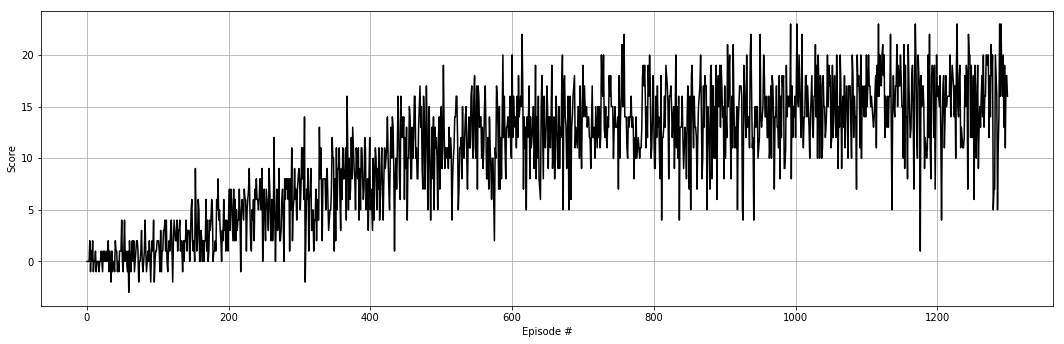

In [8]:
fig, ax = plt.subplots(1, 1, figsize=[15, 5])
plt.rcParams.update({'font.size': 14})

ax.plot(np.arange(len(scores)), scores, c='black')
ax.set_ylabel('Score')
ax.set_xlabel('Episode #')
ax.grid(which="major")

fig.tight_layout()
fig.savefig("result_score.jpg")

# 4. Agent Playing - Post Training

In [9]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0, pretrained_model_file='checkpoint.pth')
scores = interact(env, agent, n_episodes=100, train=False)

Episode 59	Average Score: 13.58

KeyError: 'BananaBrain'

In [10]:
env.close()

In [6]:
import numpy as np
import random
from collections import namedtuple, deque

import torch
import torch.nn.functional as F
import torch.optim as optim

from model import QNetwork
from model import ReplayBuffer

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
state_size = state_size
action_size = action_size
seed = 0
buffer_size = int(1e5)
batch_size = 64
gamma = 0.99
tau = 1e-3
lr = 5e-4
update_every = 4

qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
optimizer = optim.Adam(qnetwork_local.parameters(), lr=lr)

In [9]:
env_info = env.reset(train_mode=False)[brain_name]
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
memory = deque(maxlen=buffer_size)

while True:
    state = env_info.vector_observations[0]
    action = np.random.randint(action_size)      
    env_info = env.step(action)[brain_name] 
    next_state = env_info.vector_observations[0]      
    reward = env_info.rewards[0]                      
    done = env_info.local_done[0]
    e = experience(state, action, reward, next_state, done)
    memory.append(e)
    if done:
        break

In [12]:
len(memory)

300

In [14]:
experiences = random.sample(memory, k=batch_size)

states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

In [16]:
states.shape

torch.Size([64, 37])

In [17]:
actions.shape

torch.Size([64, 1])

In [18]:
Q_targets_next = qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

In [27]:
qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1).shape

torch.Size([64, 1])

In [28]:
qnetwork_target(next_states).detach().max(1)[0].shape

torch.Size([64])